In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
import pickle

### Loading wholesale market price for HQ (https://www.nyiso.com/custom-reports)

In [2]:
import pandas as pd

# Load the CSV file
file_path = 'datasets/HQRTLMP.csv'
data = pd.read_csv(file_path, parse_dates=['RTD End Time Stamp'])

# Filter the records from 2018-01-01 00:00:00 to 2018-03-01 23:45:00
start_date = '2018-01-01 00:00:00'
end_date = '2018-03-01 23:45:00'
filtered_data = data[(data['RTD End Time Stamp'] >= start_date) & (data['RTD End Time Stamp'] <= end_date)]

# Remove duplicates by keeping the first occurrence
filtered_data = filtered_data.drop_duplicates(subset=['RTD End Time Stamp'])

# Generate expected timestamps
expected_timestamps = pd.date_range(start=start_date, end=end_date, freq='5T')

# Set the RTD End Time Stamp column as index
filtered_data.set_index('RTD End Time Stamp', inplace=True)

# Reindex the dataframe to insert missing intervals
filtered_data = filtered_data.reindex(expected_timestamps)

# Forward fill missing values
filtered_data['RTD Zonal LBMP'].fillna(method='ffill', inplace=True)

# Reset index to get RTD End Time Stamp back as a column
filtered_data.reset_index(inplace=True)
filtered_data.rename(columns={'index': 'RTD End Time Stamp'}, inplace=True)

# Keep only the 'RTD End Time Stamp' and 'RTD Zonal LBMP' columns
HQRTLMP = filtered_data[['RTD End Time Stamp', 'RTD Zonal LBMP']].copy()
HQRTLMP.rename(columns={'RTD End Time Stamp': 'Time', 'RTD Zonal LBMP': 'P'}, inplace=True)
HQRTLMP.P *= 1.3511/1000 #changed price from US$/MWh to CA$/kWh -> usd to cad conversion rate average for the last year on 5/16/2024 was 1.3511, 
HQRTLMP.set_index('Time', inplace=True)
HQRTLMP

,P
Time,
2018-01-01 00:00:00,0.058543
2018-01-01 00:05:00,0.058543
2018-01-01 00:10:00,0.070419
2018-01-01 00:15:00,0.076324
2018-01-01 00:20:00,0.066285
...,...
2018-03-01 23:25:00,0.015132
2018-03-01 23:30:00,0.017145
2018-03-01 23:35:00,0.017200


### Creating Desired Temperature

In [3]:
# Define transition and working hours in 5-minute intervals
transition_intervals = 12  # 1 hour
work_start = 9 * 12
work_end = 17 * 12

# Create a single day temperature profile
day_profile = np.ones(24 * 12) * 18
day_profile[work_start:work_end] = 22

# Smooth transition up
for i in range(transition_intervals):
    day_profile[work_start - transition_intervals + i] = 18 + (4 * i) / transition_intervals

# Smooth transition down
for i in range(transition_intervals):
    day_profile[work_end + i] = 22 - (4 * i) / transition_intervals

# Repeat the daily profile to create a weekly profile
T_des = np.tile(day_profile, 60)

In [4]:
db = pd.read_csv('datasets/ds4-Varennes-library.csv')
df = db[['Time', 'cons_noheating [kW]', 'T_ext', 'light_cons [kW]', 'heating_total [kW]', 'prod [kW]']].copy()
df.loc[:,'non_reducible'] = df['cons_noheating [kW]'] - df['light_cons [kW]']
# df['non_reducible'][df['non_reducible']<0] = 0
for i in df.index:
    if df.loc[i, 'non_reducible'] < 0:
        df.loc[i, 'non_reducible'] = (df.loc[i-1, 'non_reducible'] + df.loc[i+1, 'non_reducible']) / 2
time_range = pd.date_range(start='2018-01-01 00:00:00', end='2018-03-01 23:45:00', freq='15T')
df.loc[:,'Time'] = time_range
# df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)

# Resample to 5-minute intervals
data = df.resample('5T').asfreq()

# Extract hour and minute
data['hour'] = data.index.hour
data['minute'] = data.index.minute

# Calculate sin and cos
data['cos'] = (np.cos(2 * np.pi * (data['hour']*60 + data['minute']) / (24*60)) + 1) / 2
data['sin'] = (np.sin(2 * np.pi * (data['hour']*60 + data['minute']) / (24*60)) + 1) / 2

# Drop the 'hour' column
data = data.drop(columns=['hour', 'minute'])

# Interpolate 'T_ext'
data['Temp [°C]'] = data['T_ext'].interpolate(method='linear')

data['pv [kWh]'] = df['prod [kW]'].reindex(data.index).ffill().bfill() * (4/3) / 3
data['non_reducible [kWh]'] = df['non_reducible'].reindex(data.index).ffill().bfill() * (4/3) / 3
data['reducible [kWh]'] = df['light_cons [kW]'].reindex(data.index).ffill().bfill() * (4/3) / 3
data['heating [kWh]'] = df['heating_total [kW]'].reindex(data.index).ffill().bfill() * (4/3) / 3
data.drop(['cons_noheating [kW]', 'T_ext', 'non_reducible', 'heating_total [kW]', 'light_cons [kW]', 'prod [kW]'], axis = 1, inplace=True)


# Adding wholesale market price to df
data['P [$/kWh]'] = HQRTLMP['P'].copy()


## adding des temp
data['Des Temp [°C]'] = T_des[:-2]

def check_time_range(row):
    hour = row.name.hour
    # Check if hour is in the range 6-9 AM or 4-8 PM
    return 1 if (6 <= hour < 9) or (16 <= hour < 20) else 0

# Apply the function to each row to create a new column
data['peak'] = data.apply(check_time_range, axis=1)


def check_working_day(row):
    wd = row.name.weekday()
    # Check if hour is in the range 6-9 AM or 4-8 PM
    return 0 if wd >= 5 else 1

# Apply the function to each row to create a new column
data['working_day'] = data.apply(check_working_day, axis=1)

# Save dataframes
with open('datasets/df.pkl', 'wb') as f:
  pickle.dump(data, f)

data

,cos,sin,Temp [°C],pv [kWh],non_reducible [kWh],reducible [kWh],heating [kWh],P [$/kWh],Des Temp [°C],peak,working_day
Time,,,,,,,,,,,
2018-01-01 00:00:00,1.000000,0.500000,-21.857000,0.0,3.272667,0.0,16.900444,0.058543,18.0,0,1
2018-01-01 00:05:00,0.999881,0.510907,-21.852333,0.0,3.272667,0.0,16.900444,0.058543,18.0,0,1
2018-01-01 00:10:00,0.999524,0.521810,-21.847667,0.0,3.272667,0.0,16.900444,0.070419,18.0,0,1
2018-01-01 00:15:00,0.998929,0.532702,-21.843000,0.0,2.886444,0.0,11.698667,0.076324,18.0,0,1
2018-01-01 00:20:00,0.998097,0.543578,-21.880667,0.0,2.886444,0.0,11.698667,0.066285,18.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2018-03-01 23:25:00,0.994181,0.423938,-1.553667,0.0,6.211778,0.0,2.075556,0.015132,18.0,0,1
2018-03-01 23:30:00,0.995722,0.434737,-1.612000,0.0,6.080556,0.0,3.027111,0.017145,18.0,0,1
2018-03-01 23:35:00,0.997028,0.445567,-1.679333,0.0,6.080556,0.0,3.027111,0.017200,18.0,0,1


In [5]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import pickle
import itertools
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

class REF_Model:
    def __init__(self, day, C, R, h):
        self.day = day
        self.C = C
        self.R = R
        self.h = h
        self.T = 24 * 12
        self.load_temperature_data()
        self.model = None
        self.B_values = None
        self.T_in_ref_values = None

    def load_temperature_data(self):
        with open(r'datasets/df.pkl', 'rb') as f:
            db = pickle.load(f)
        self.T_out = np.array(db.iloc[self.T*(self.day-1):self.T*self.day,:]['Temp [°C]']).reshape(self.T)
        self.T_des = np.array(db.iloc[self.T*(self.day-1):self.T*self.day,:]['Des Temp [°C]']).reshape(self.T)
    
    def setup_model(self):
        self.model = gp.Model("HVAC_Optimization")
        self.model.setParam('OutputFlag', 0)
        self.model.setParam('MIPGap', 0.01)
        self.model.setParam('TimeLimit', 1000)
        # self.model.setParam('MIPGap', 0.1)
        # self.model.setParam('TimeLimit', 100)
        B_ref = self.model.addVars(self.T, vtype=GRB.BINARY, name="B_ref")
        T_in_ref = self.model.addVars(self.T, lb=-GRB.INFINITY, name="T_in_ref")
        y = self.model.addVars(self.T, name="y")
        obj_ref = gp.quicksum(y[t] for t in range(self.T))
        self.model.setObjective(obj_ref, GRB.MINIMIZE)
        self.model.addConstr(T_in_ref[0] == self.T_des[0])
        for t in range(1, self.T):
            self.model.addConstr(T_in_ref[t] == T_in_ref[t-1] + ((self.T_out[t] - T_in_ref[t-1])/self.R + B_ref[t]*self.h)*(5/self.C), name=f"Temperature_{t}")
            self.model.addConstr(y[t] >= self.T_des[t] - T_in_ref[t], name=f"Linearization_pos_{t}")
            self.model.addConstr(y[t] >= -(self.T_des[t] - T_in_ref[t]), name=f"Linearization_neg_{t}")

    def solve(self):
        self.setup_model()
        self.model.optimize()
        self.B_values = [self.model.getVarByName(f"B_ref[{t}]").x for t in range(self.T)]
        self.T_in_ref_values = [self.model.getVarByName(f"T_in_ref[{t}]").x for t in range(self.T)]

    def get_results(self):
        return self.B_values, self.T_in_ref_values

def run_simulation(params):
    day, C, R, h = params
    model = REF_Model(day, C, R, h)
    model.solve()
    return params, model.get_results()

def run_for_all_combinations():
    results = {}
    days = range(1, 57)
    C_values = [100, 150]
    R_values = [1, 2]
    h_values = [50, 80]

    combinations = list(itertools.product(days, C_values, R_values, h_values))
    progress_bar = tqdm(total=len(combinations), desc='Processing')

    with ThreadPoolExecutor() as executor:
        future_to_params = {executor.submit(run_simulation, params): params for params in combinations}
        for future in as_completed(future_to_params):
            params, result = future.result()
            progress_bar.update(1)
            results[params] = result

    progress_bar.close()
    with open('datasets/ref_res.pkl', 'wb') as f:
        pickle.dump(results, f)

    return results

# Call the function to run the model for all combinations and get results
results = run_for_all_combinations()


Processing:   0%|          | 0/448 [00:00<?, ?it/s]

Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09
Academic license - for non-commercial use only - expires 2024-12-09
Academic license - for non-commercial use only - expires 2024-12-09
Academic license - for non-commercial use only - expires 2024-12-09
Academic license - for non-commercial use only - expires 2024-12-09
Academic license - for non-commercial use only - expires 2024-12-09
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-09
Academic license - for non-commercial use o

Processing:   0%|          | 1/448 [16:48<125:16:32, 1008.93s/it]

Freeing default Gurobi environment
Freeing default Gurobi environment
Freeing default Gurobi environment
Freeing default Gurobi environment
Freeing default Gurobi environment
Freeing default Gurobi environment
Freeing default Gurobi environment
Freeing default Gurobi environment
Freeing default Gurobi environment
Freeing default Gurobi environment
Freeing default Gurobi environment
Freeing default Gurobi environment
Freeing default Gurobi environment
Freeing default Gurobi environment


Processing: 100%|██████████| 448/448 [4:05:09<00:00, 32.83s/it]  


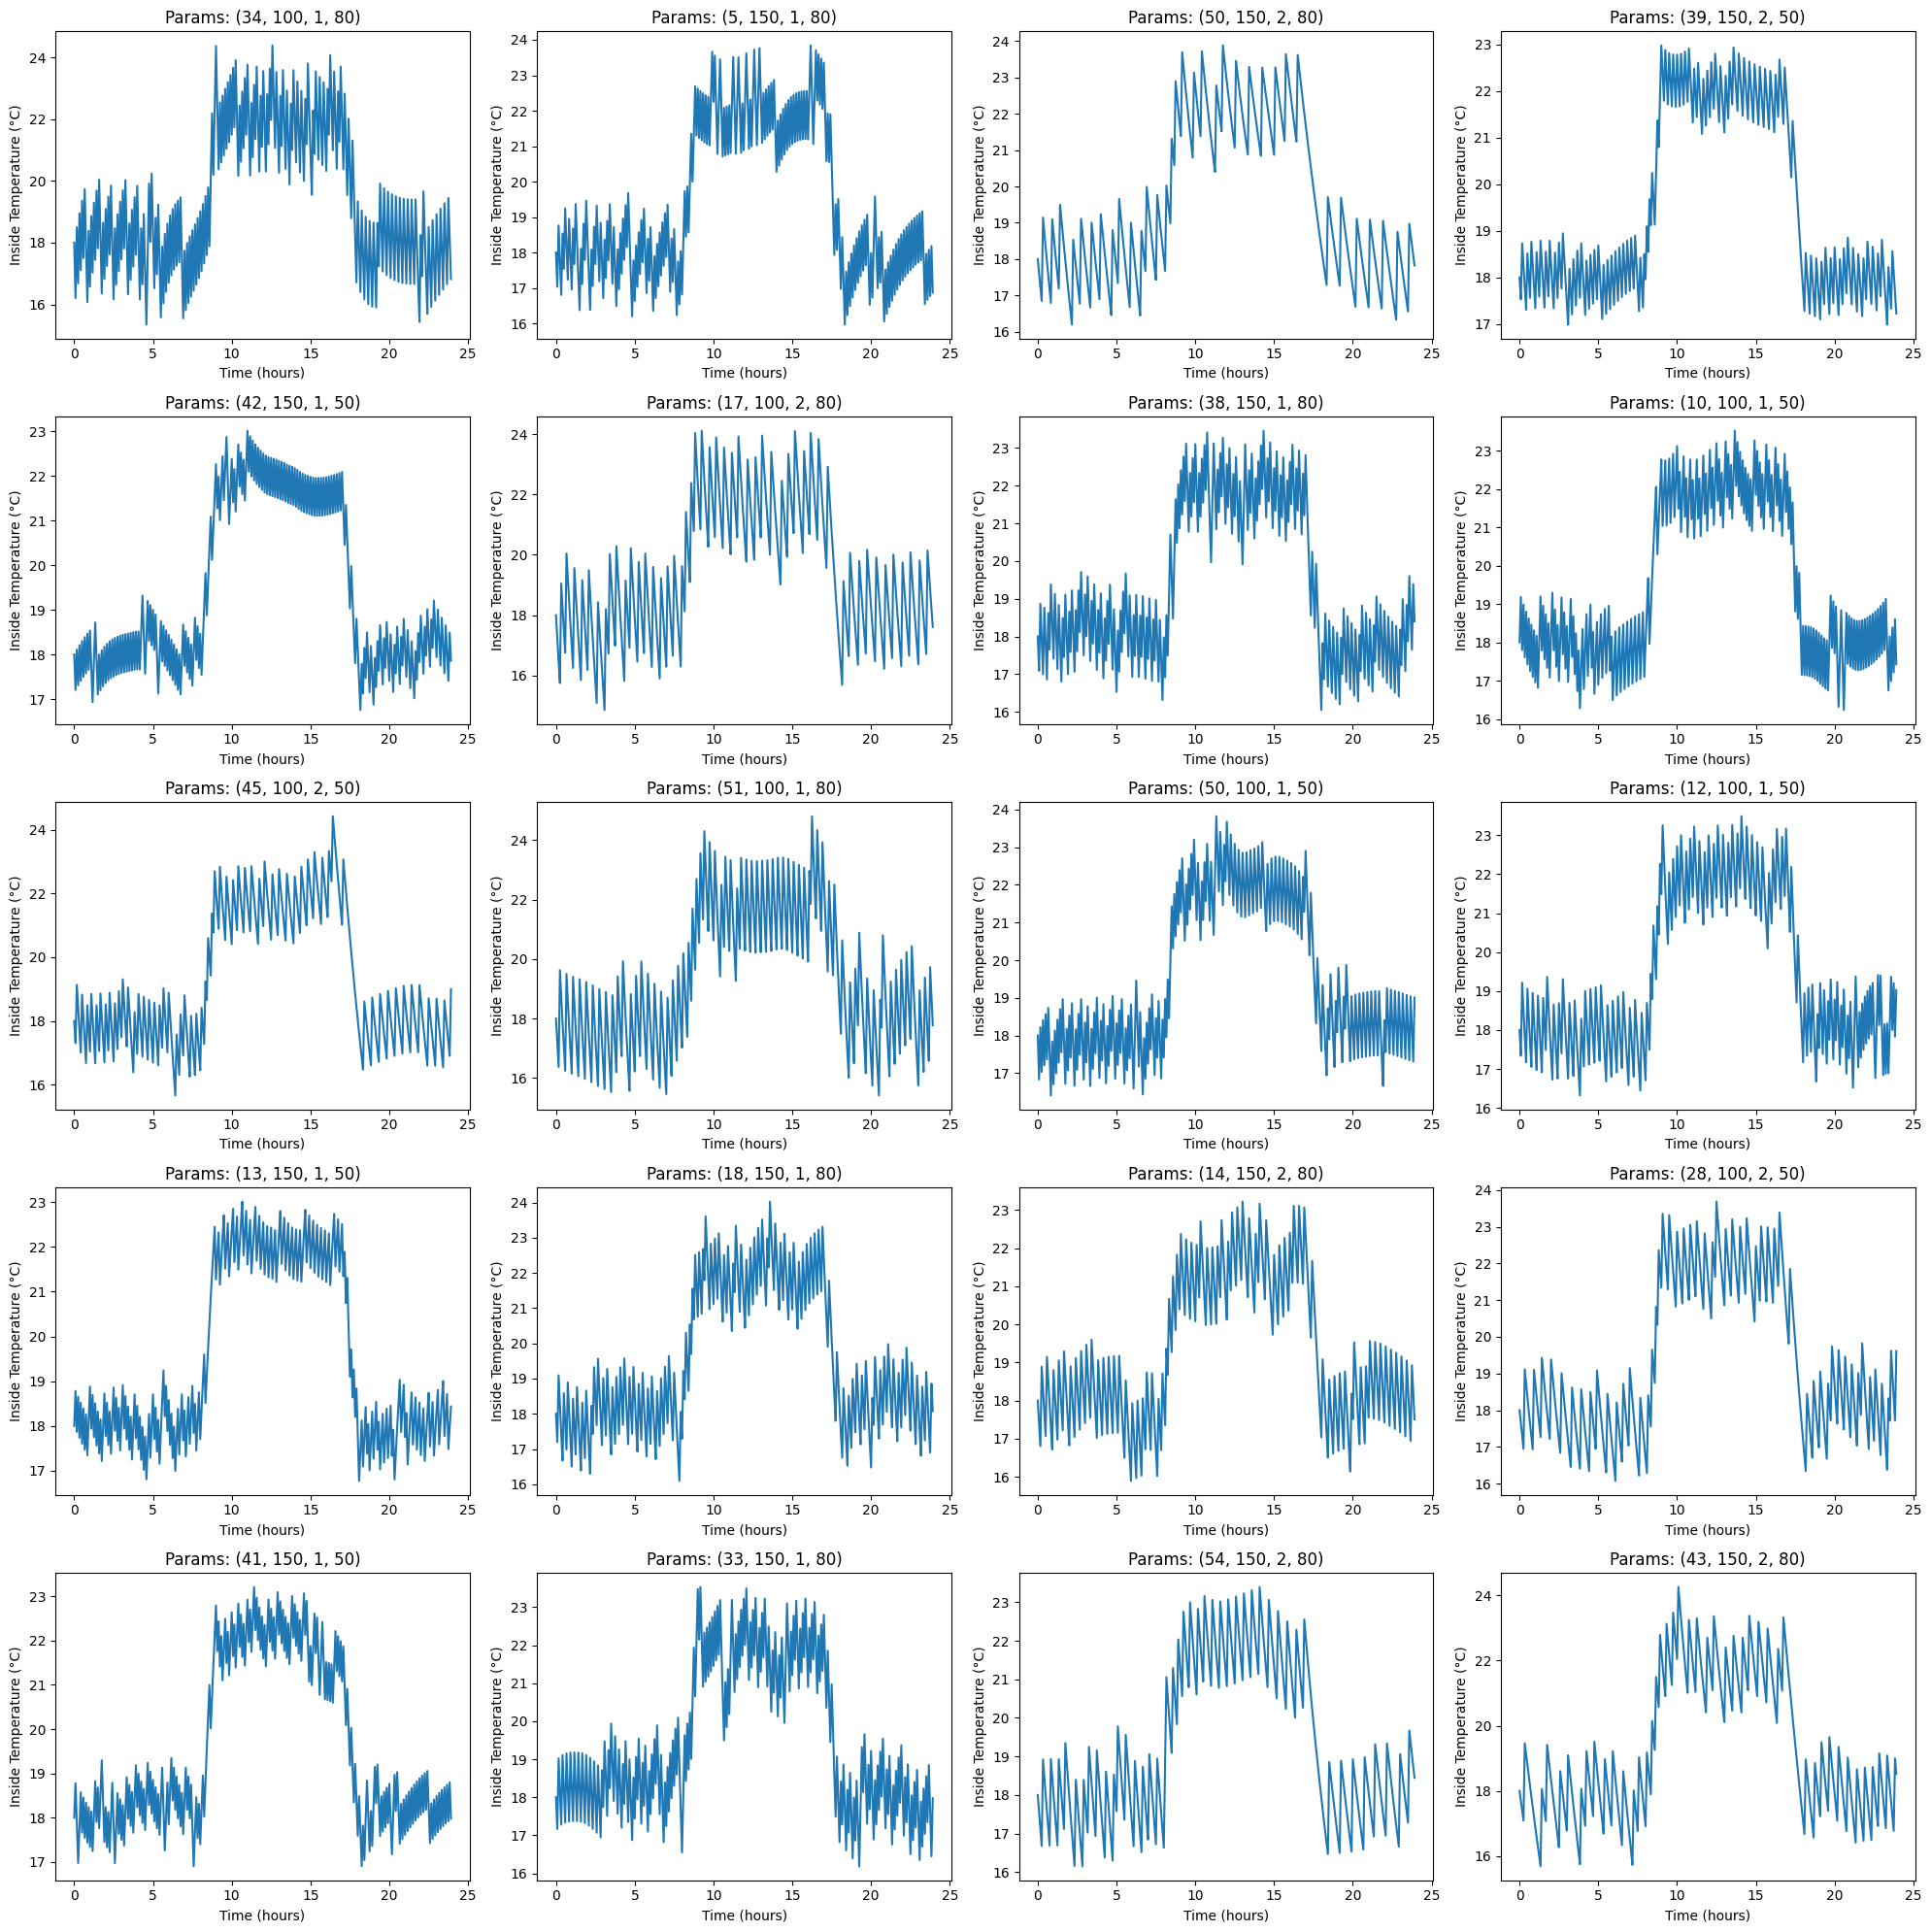

In [6]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random

# Load the saved results
with open('datasets/ref_res.pkl', 'rb') as f:
    results = pickle.load(f)

# Select 20 random parameter combinations
random_params = random.sample(list(results.keys()), 20)

# Time steps in a day with 5-minute intervals
time_steps = np.arange(24 * 12) * 5 / 60

# Create plots for each selected parameter combination
fig, axs = plt.subplots(5, 4, figsize=(20, 20))  # Adjust subplot layout as needed
axs = axs.flatten()

for i, params in enumerate(random_params):
    T_in_ref_values = results[params][1]
    axs[i].plot(time_steps, T_in_ref_values)
    axs[i].set_title(f'Params: {params}')
    axs[i].set_xlabel('Time (hours)')
    axs[i].set_ylabel('Inside Temperature (°C)')

plt.tight_layout()
plt.show()
